In [1]:
import sklearn.model_selection
import torch
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import seaborn
import pandas
import numpy

In [2]:
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

default_device = "cpu"
if torch.cuda.is_available():
    default_device = "cuda"

torch.set_default_device(default_device)

In [3]:
data = pandas.read_csv("../datasets/bikesharing.csv", index_col=0)
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


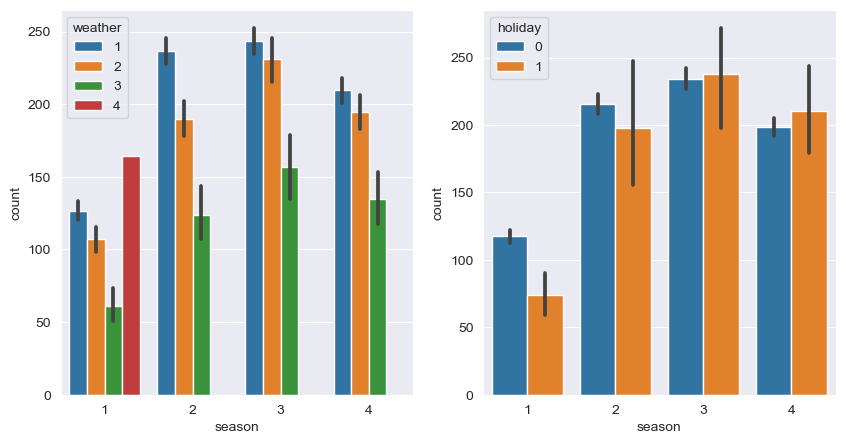

In [4]:
figure, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

seaborn.barplot(x='season', y='count', hue='weather', data=data, ax=axs[0])
seaborn.barplot(x='season', y='count', hue='holiday', data=data, ax=axs[1])

plt.show()

In [5]:
features = data[['registered', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'season']]
labels = data[['count']]

,registered,holiday,workingday,weather,temp,atemp,season
datetime,,,,,,,
2011-01-01 00:00:00,13,0,0,1,9.84,14.395,1
2011-01-01 01:00:00,32,0,0,1,9.02,13.635,1
2011-01-01 02:00:00,27,0,0,1,9.02,13.635,1
2011-01-01 03:00:00,10,0,0,1,9.84,14.395,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,1


In [6]:
# Split the dataset into training and validation sets
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(features, labels, test_size=0.2)

x_train_tensor = torch.tensor(x_train.values, dtype=default_dtype)
x_test_tensor = torch.tensor(x_test.values, dtype=default_dtype)
y_train_tensor = torch.tensor(y_train.values, dtype=default_dtype)
y_test_tensor  = torch.tensor(y_test.values, dtype=default_dtype)

train_data = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = data_utils.DataLoader(train_data, batch_size=1000, shuffle=True, generator=torch.Generator(device=default_device))

In [7]:
input_layer = x_train_tensor.shape[1]
hidden_layer = 100
output_layer = 1
learning_rate = 1e-4
epochs = 1_000

model = torch.nn.Sequential(torch.nn.Linear(input_layer, hidden_layer), torch.nn.ReLU(), torch.nn.Linear(hidden_layer, output_layer))
cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
    epoch_id = i + 1

    for (f, l) in train_loader:
        predicted = model(f)
        loss = cost_function(predicted, l)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


Model was evaluated with score of 0.961967122831711


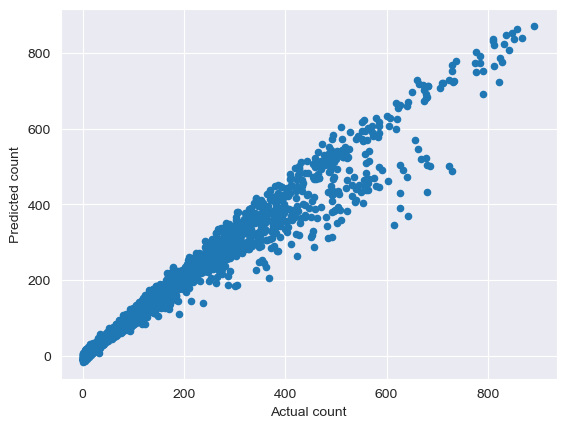

In [8]:
model.eval()

with torch.no_grad():
    final_prediction = numpy.array(model(x_test_tensor).detach().cpu())

score = sklearn.metrics.r2_score(y_test, final_prediction)
print(f"Model was evaluated with score of {score}")

plt.scatter(y_test.values, final_prediction, s=20)
plt.xlabel("Actual count")
plt.ylabel("Predicted count")

plt.show()